In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

GPU is available


In [6]:
df = pd.read_csv('stock_data.csv')
df.head()

,Text,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X, y = df['Text'].values, df['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (38956,)
shape of test data is (12986,)


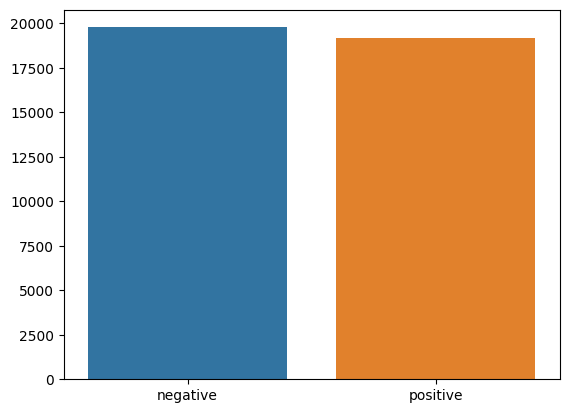

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative', 'positive']), y=dd.values)
plt.show()

In [11]:
def preprocess_string(s):
    '''
    删除所有的空白字符,标点符号,数字
    '''
    #删除所有既不是单词字符也不是空白字符的字符
    s = re.sub(r"[^\w\s]", '', s)
    #删除所有一个或多个连续的空白字符
    s = re.sub(r"\s+", '', s)
    #删除所有数字
    s = re.sub(r"\d", '', s)
    
    return s

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []
    #所有的英语停用词,如the,is,at
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
                
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}
    
    final_list_train, final_list_test = [], []
    
    for sent in x_train:
        final_list_train.append([onehot_dict[preprocess_string(word)] 
                                 for word in sent.lower().split()
                                if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
        final_list_test.append([onehot_dict[preprocess_string(word)]
                                            for word in sent.lower().split()
                                           if preprocess_string(word) in onehot_dict.keys()])
        encoded_train = [1 if label == 'positive' else 0 for label in y_train]
        encoded_test = [1 if label == 'positive' else 0 for label in y_val]
        
    return final_list_train, encoded_train, final_list_test,encoded_test, onehot_dict

In [12]:
x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test)

In [25]:
print(f'length of vocabulary is {len(vocab)}')

length of vocabulary is 1000


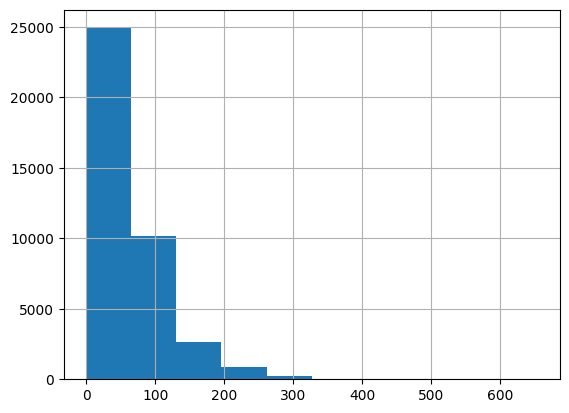

count    38956.000000
mean        66.596185
std         48.703336
min          0.000000
25%         37.000000
50%         53.000000
75%         82.000000
max        653.000000
dtype: float64

In [27]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [28]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
            
    return features

In [29]:
x_train_pad = padding_(x_train, 500)
x_test_pad = padding_(x_test, 500)

In [33]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [34]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [36]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size:', sample_x.size()) #batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size: torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   0, 968, 968],
        [  0,   0,   0,  ..., 232, 428,  24],
        [  0,   0,   0,  ...,   4, 234, 626],
        ...,
        [  0,   0,   0,  ...,   6, 138,   3],
        [  0,   0,   0,  ...,  38, 184,   9],
        [  0,   0,   0,  ...,  25,  63,   4]])
Sample input: 
 tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1])


Model

In [37]:
class SentimentRNN(nn.Module):
    
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim,drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        
        #embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        #dropout layer
        self.dropout = nn.Dropout(0.5)
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embedding and lstm_out
        embeds = self.embedding(x) #shape: B * S * Feature since batch = True
        #print(embeds.shape) #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        #dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        create two new tensors with sizes n_layers * batch_size * hidden_dim
        initialized to zero, for hidden state and cell state of LSTM
        '''
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [38]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim,drop_prob=0.5)
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Training

In [41]:
#loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [42]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
#train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    #initialize hidden state
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        #creating new variables for the hidden state, otherwise
        #we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output, h = model(inputs, h)
        
        #calc loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calc accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        #clip_grad_norm helps prevent the exploding gradient problem in RNN/LSTM
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])
        inputs, labels = inputs.to(device), labels.to(device)
        
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())
        
        accuracy = acc(output, labels)
        val_acc += accuracy
        
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    
    print(f'Epoch {epoch + 1}')
    print(f'train_loss : {epoch_train_loss} val_loss: {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_loss: {epoch_val_acc*100}')
    
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
        
    print(25*'==')

Epoch 1
train_loss : 0.6900567216882351 val_loss: 0.6912489795776868
train_accuracy : 52.74668857172195 val_loss: 52.09456337594332
Validation loss decreased (inf --> 0.691249). Saving model...
Epoch 2
train_loss : 0.5765929988206427 val_loss: 0.41069227503073263
train_accuracy : 67.99466064277647 val_loss: 81.58016325273371
Validation loss decreased (0.691249 --> 0.410692). Saving model...
Epoch 3
train_loss : 0.37144140153166877 val_loss: 0.3491868962422301
train_accuracy : 83.67902248690831 val_loss: 84.6296011088865
Validation loss decreased (0.410692 --> 0.349187). Saving model...
Epoch 4
train_loss : 0.3328392266634187 val_loss: 0.33473822405439546
train_accuracy : 85.61967347776978 val_loss: 85.20714615740029
Validation loss decreased (0.349187 --> 0.334738). Saving model...
Epoch 5
train_loss : 0.3116850772435001 val_loss: 0.33152604684176135
train_accuracy : 86.57459698120957 val_loss: 85.19944555675343
Validation loss decreased (0.334738 --> 0.331526). Saving model...


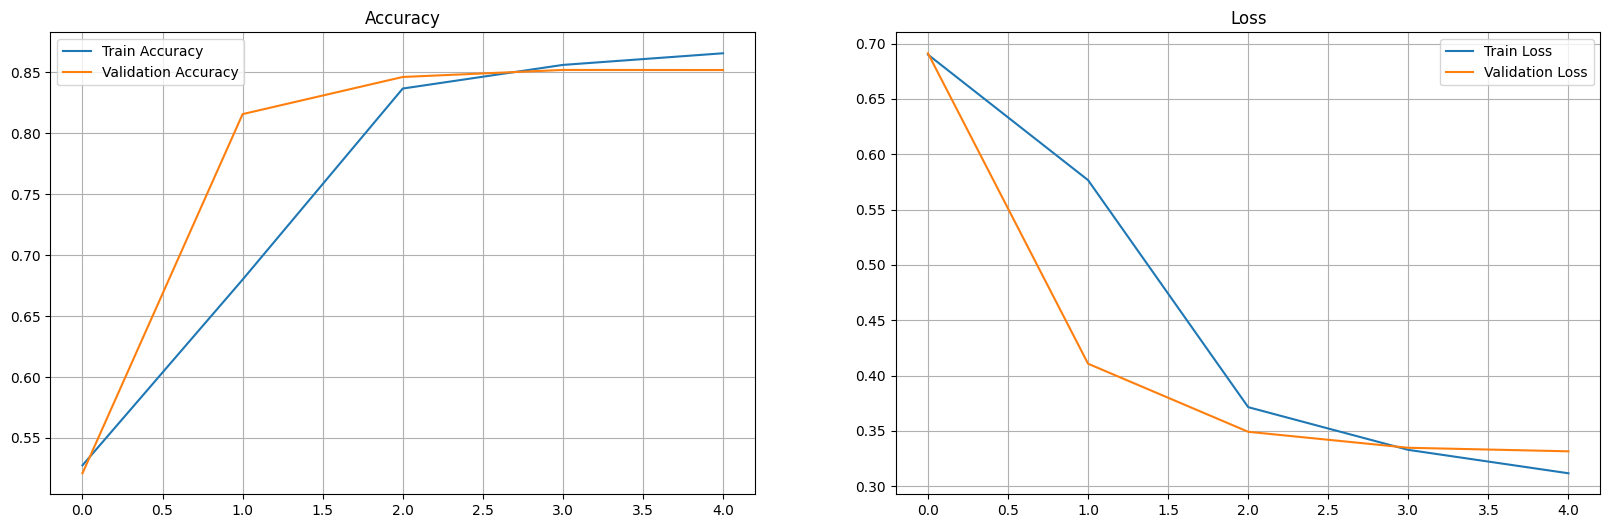

In [44]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(epoch_tr_acc, label='Train Accuracy')
plt.plot(epoch_vl_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epoch_tr_loss, label='Train Loss')
plt.plot(epoch_vl_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.show()

In [45]:
def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())

In [46]:
pro = predict_text("​Mukul Agrawal's Portfolio: 6 increases over 100% in 2023 so far")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.670587420463562


In [47]:
pro = predict_text("Apple releases new iPhone at WWDC")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.8728097081184387


In [48]:
pro = predict_text("Large Cap Auto stock falls 4% after ED raids Chairman’s residence; Check the details")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.6744025349617004


In [49]:
pro = predict_text("Adani stocks gain over Rs 71,000 crore in July")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.7741625905036926


In [50]:
pro = predict_text("India's crude oil imports from Saudi Arabia drop 34% in July")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.7741625905036926


In [51]:
pro = predict_text("Stock Market LIVE Updates: Nifty below 19,650, Sensex falls 400 pts dragged by metal, IT, FMCG")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.6744025349617004


In [52]:
pro = predict_text("Bandhan Bank stock jumps 1.6% as Societe Generale acquires 1% stake for Rs 382 cr")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.7741625905036926


In [53]:
pro = predict_text("Power Grid Shares falls Over 5%")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.6744025349617004


In [54]:
pro = predict_text("Stock Market LIVE Updates: Nifty below 19,650, Sensex falls 400 pts dragged by metal, IT, FMCG")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.6744025349617004


In [55]:
pro = predict_text("Samsung bets on India to drive business growth in H2")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')


predicted sentiment is positive with a probability of 0.8346858024597168
